In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import import_ipynb
from one_iv_computation import get_spot_and_risk_free_rate 
import seaborn as sns

current SPY Price: $694.0700073242188
Risk-Free Rate: 0.041710000038146976 (4.171000003814697%)
Total calls: 865 (liquid: 405)

sample call options:
    strike    bid    ask  lastPrice  volume  impliedVolatility      expiry  \
1    640.0  52.62  55.41      54.37   280.0           0.630497  2026-01-12   
2    645.0  47.64  50.42      49.88   214.0           0.584721  2026-01-12   
3    650.0  42.64  45.38      44.52    23.0           0.533452  2026-01-12   
9    664.0  28.65  31.43      30.64    27.0           0.403204  2026-01-12   
10   665.0  27.64  30.43      29.05    11.0           0.393317  2026-01-12   

    dte     mid  
1     1  54.015  
2     1  49.030  
3     1  44.010  
9     1  30.040  
10    1  29.035  
successfully computed IVs, moving onto analysis...


sample comparison (c):
    strike      expiry  impliedVolatility  computed_iv   iv_diff
32   687.0  2026-01-12           0.082162     0.068897 -0.013265
33   688.0  2026-01-12           0.077890     0.109156  0.031266
34 

In [ ]:
calls_df = pd.read_csv('spy_calls_liquid.csv')
puts_df = pd.read_csv('spy_puts_liquid.csv')

# ATM strikes give (approx) current spot prices 
current_price, _ = get_spot_and_risk_free_rate()

# clean
calls_clean = calls_df.dropna(subset=['computed_iv']).copy()
puts_clean = puts_df.dropna(subset=['computed_iv']).copy()

calls_clean['moneyness'] = calls_clean['strike'] / current_price
calls_clean['T'] = calls_clean['dte'] / 365.0

puts_clean['moneyness'] = puts_clean['strike'] / current_price
puts_clean['T'] = puts_clean['dte'] / 365.0

using spot price: 694.0700073242188


In [5]:
# grid for calls 
n_points = 500 # finer grain
moneyness_min = max(0.85, calls_clean['moneyness'].min())
moneyness_max = min(1.15, calls_clean['moneyness'].max())
T_min = calls_clean['T'].min()
T_max = calls_clean['T'].max()

moneyness_grid = np.linspace(moneyness_min, moneyness_max, n_points)
T_grid = np.linspace(T_min, T_max, n_points)
M, T = np.meshgrid(moneyness_grid, T_grid, indexing = 'ij')

IV_surface_calls = griddata(points=(calls_clean['moneyness'], calls_clean['T']),
    values=calls_clean['computed_iv'],
    xi=(M, T),
    method='cubic')


# grid for puts
n_points = 500
moneyness_min = max(0.85, puts_clean['moneyness'].min())
moneyness_max = min(1.15, puts_clean['moneyness'].max())
T_min = puts_clean['T'].min()
T_max = puts_clean['T'].max()

moneyness_grid = np.linspace(moneyness_min, moneyness_max, n_points)
T_grid = np.linspace(T_min, T_max, n_points)
M, T = np.meshgrid(moneyness_grid, T_grid)

# cubic interpolation 
IV_surface_puts = griddata(points=(puts_clean['moneyness'], puts_clean['T']),
    values=puts_clean['computed_iv'], xi=(M, T), method='cubic'
)

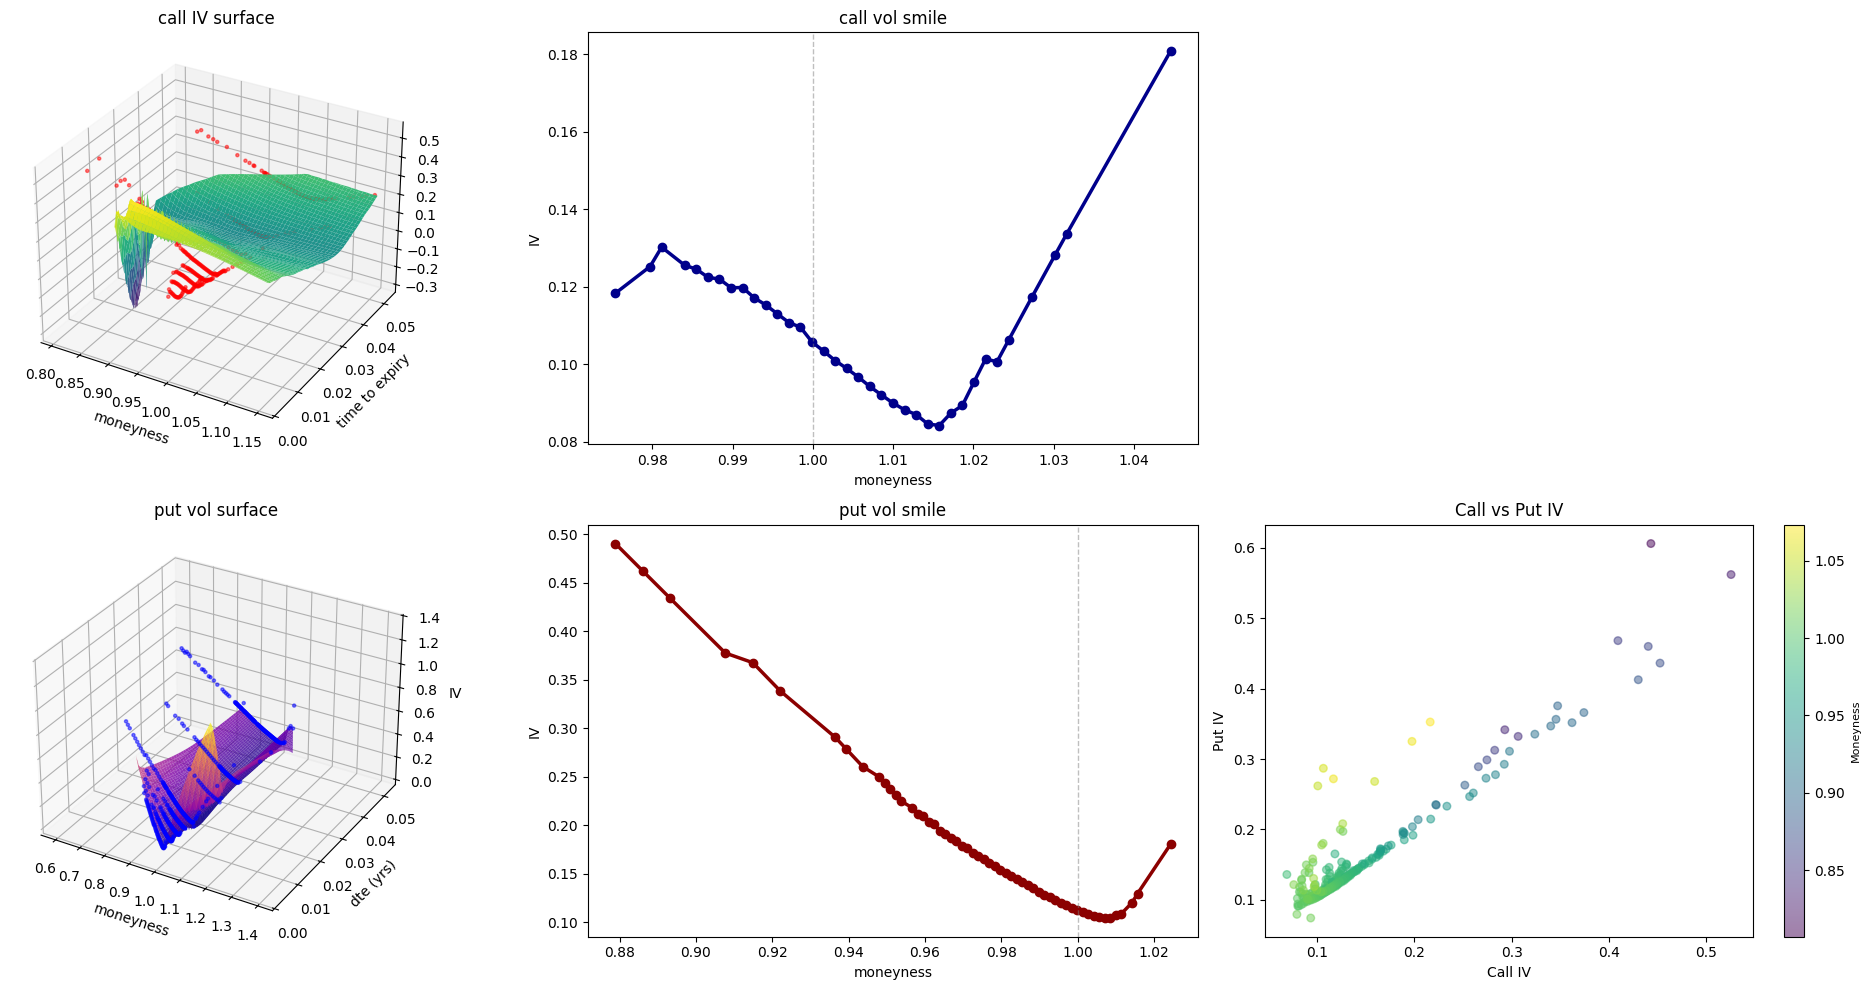

In [11]:
fig = plt.figure(figsize=(20, 10))

# call vol surface
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
surface = ax1.plot_surface(M, T, IV_surface_calls, cmap='viridis', edgecolor='none')
ax1.scatter(calls_clean['moneyness'], calls_clean['T'], calls_clean['computed_iv'], c='red', s=5, alpha=0.5)
ax1.set_xlabel('moneyness')
ax1.set_ylabel('time to expiry')
ax1.set_title('call IV surface')

# call vol smile (single expiry)
ax2 = fig.add_subplot(2, 3, 2)

expiry_call = sorted(calls_clean['expiry'].unique())[2]  # 3rd expiry
exp_data_call = calls_clean[calls_clean['expiry'] == expiry_call].sort_values('moneyness')
dte_call = exp_data_call['dte'].iloc[0]
ax2.plot(exp_data_call['moneyness'], exp_data_call['computed_iv'], 
        marker='o', linewidth=2.5, markersize=6, color='darkblue')
ax2.axvline(x=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('moneyness')
ax2.set_ylabel('IV')
ax2.set_title(f'call vol smile')

# put vol surface 
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
surf2 = ax4.plot_surface(M, T, IV_surface_puts, cmap='plasma', 
                         alpha=0.8)
ax4.scatter(puts_clean['moneyness'], puts_clean['T'], 
           puts_clean['computed_iv'], c='blue', s=5, alpha=0.5)
ax4.set_xlabel('moneyness')
ax4.set_ylabel('dte (yrs)')
ax4.set_zlabel('IV')
ax4.set_title('put vol surface')

# put vol smile (single expiry)
ax5 = fig.add_subplot(2, 3, 5)
expiry_put = sorted(puts_clean['expiry'].unique())[2]  # 3rd expiry
exp_data_put = puts_clean[puts_clean['expiry'] == expiry_put].sort_values('moneyness')
dte_put = exp_data_put['dte'].iloc[0]
ax5.plot(exp_data_put['moneyness'], exp_data_put['computed_iv'], 
        marker='o', linewidth=2.5, markersize=6, color='darkred')
ax5.axvline(x=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax5.set_xlabel('moneyness')
ax5.set_ylabel('IV')
ax5.set_title(f'put vol smile')

# call vs put IV comparison
ax6 = fig.add_subplot(2, 3, 6)
merged = pd.merge(
    calls_clean[['strike', 'expiry', 'computed_iv', 'moneyness']],
    puts_clean[['strike', 'expiry', 'computed_iv']],
    on=['strike', 'expiry'],
    suffixes=('_call', '_put')
)
ax6.scatter(merged['computed_iv_call'], merged['computed_iv_put'], 
           alpha=0.5, c=merged['moneyness'], s=30)

ax6.set_xlabel('Call IV')
ax6.set_ylabel('Put IV')
ax6.set_title('Call vs Put IV')
cbar = fig.colorbar(ax6.collections[0], ax=ax6)
cbar.set_label('Moneyness', fontsize=8)

plt.tight_layout()
plt.savefig('volatility_surface_complete.png', dpi=300)
plt.show()

In [15]:
# save everything! 
IV_surface_calls = pd.DataFrame(
    IV_surface_calls,
    index=moneyness_grid,
    columns=T_grid
)

IV_surface_puts = pd.DataFrame(
    IV_surface_puts,
    index=moneyness_grid,
    columns=T_grid
)
IV_surface_calls.to_pickle('IV_surface_calls.pkl')
IV_surface_puts.to_pickle('IV_surface_puts.pkl')